In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
#from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
im_shape = (299,299)

TRAINING_DIR = '/content/drive/MyDrive/ds_frutas_am/train'
TEST_DIR = '/content/drive/MyDrive/ds_frutas_am/test'

seed = 10

BATCH_SIZE = 16



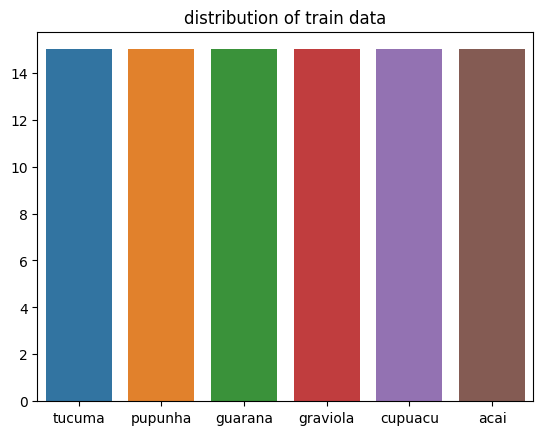

90


In [70]:
categories = []
class_count = []
train_exm = 0
for f in os.listdir(TRAINING_DIR):
    files = gb.glob(pathname=str(TRAINING_DIR  + '//' + f + '/*.jpeg'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")

plt.show()
print(train_exm)

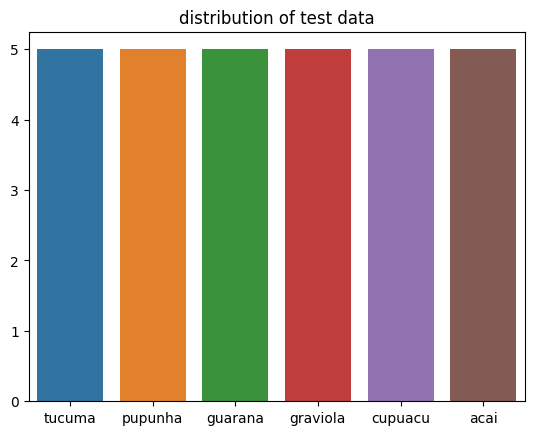

30


In [71]:
categories = []
class_count = []
train_exm = 0
for f in os.listdir(TRAINING_DIR):
    files = gb.glob(pathname=str(TEST_DIR  + '//' + f + '/*.jpeg'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of test data")

plt.show()
print(train_exm)

In [72]:
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [73]:
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
Classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)


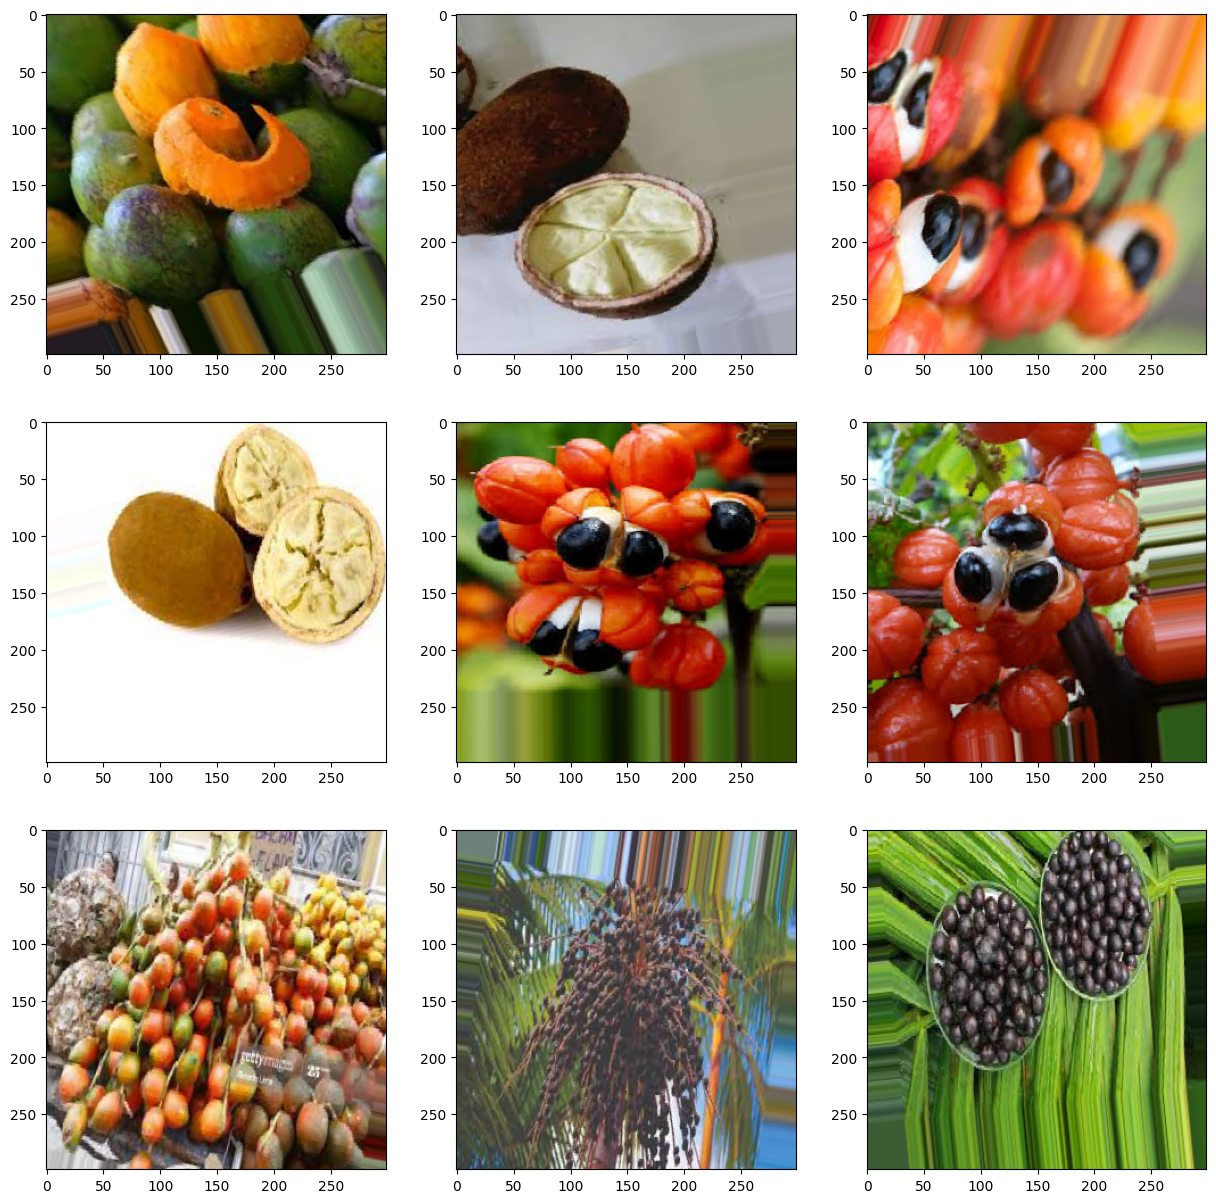

In [74]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = (train_generator.next()[0]+1)/2*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
    print(image.shape)
plt.show()

With Freezing

In [99]:
base_model =  tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1],3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [100]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(6, activation='softmax', kernel_initializer='random_uniform')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

optimizer = Adam()
model.compile(optimizer=optimizer,  loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0   

In [101]:
epochs = 10

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='tr.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]


history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 3.3926 - accuracy: 0.1071 
Epoch 1: val_loss improved from inf to 3.30074, saving model to tr.h5
4/4 [==============================] - 87s 22s/step - loss: 3.3926 - accuracy: 0.1071 - val_loss: 3.3007 - val_accuracy: 0.2500
Epoch 2/10
4/4 [==============================] - ETA: 0s - loss: 2.7200 - accuracy: 0.2500 
Epoch 2: val_loss improved from 3.30074 to 2.63260, saving model to tr.h5
4/4 [==============================] - 81s 21s/step - loss: 2.7200 - accuracy: 0.2500 - val_loss: 2.6326 - val_accuracy: 0.3750
Epoch 3/10
4/4 [==============================] - ETA: 0s - loss: 2.2005 - accuracy: 0.4062 
Epoch 3: val_loss improved from 2.63260 to 1.27107, saving model to tr.h5
4/4 [==============================] - 94s 25s/step - loss: 2.2005 - accuracy: 0.4062 - val_loss: 1.2711 - val_accuracy: 0.5625
Epoch 4/10
4/4 [==============================] - ETA: 0s - loss: 1.0980 - accuracy: 0.6429 
Epoch 4: val_loss did not 

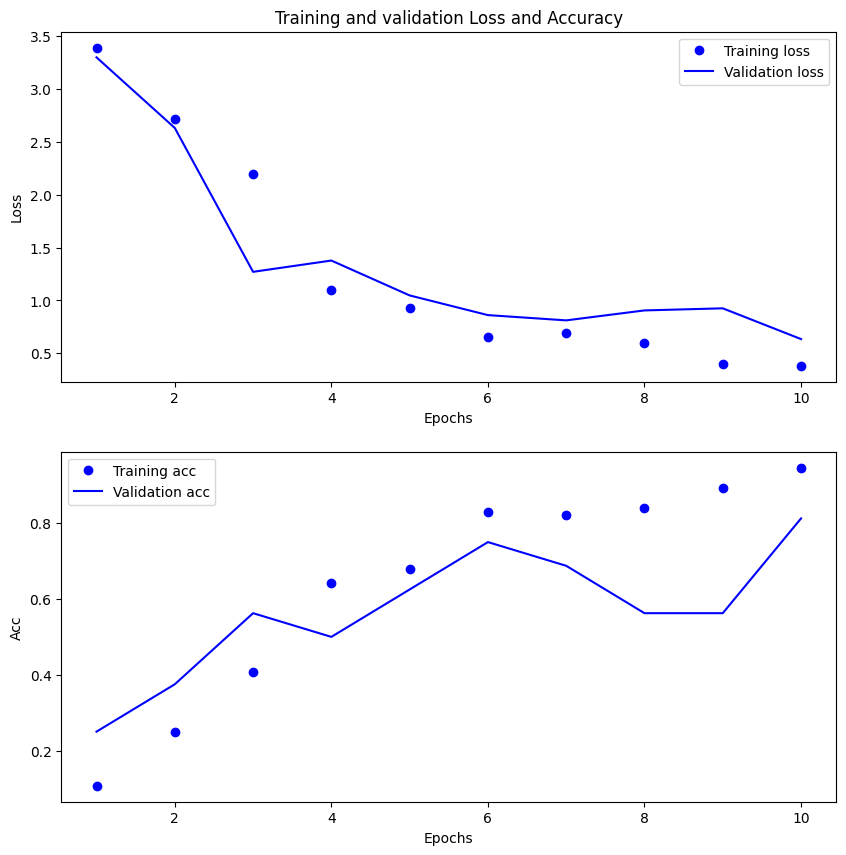

In [102]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

Without Freezing


In [120]:
base_model =  tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1],3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [121]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(6, activation='softmax', kernel_initializer='random_uniform')(x)
model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam()
model.compile(optimizer=optimizer,  loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0  

In [122]:
epochs = 10

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='tr.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]


history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 2.4708 - accuracy: 0.1786  
Epoch 1: val_loss improved from inf to 1.80432, saving model to tr.h5
4/4 [==============================] - 245s 59s/step - loss: 2.4708 - accuracy: 0.1786 - val_loss: 1.8043 - val_accuracy: 0.1875
Epoch 2/10
4/4 [==============================] - ETA: 0s - loss: 1.8288 - accuracy: 0.2188  
Epoch 2: val_loss did not improve from 1.80432
4/4 [==============================] - 272s 70s/step - loss: 1.8288 - accuracy: 0.2188 - val_loss: 2.2930 - val_accuracy: 0.1875
Epoch 3/10
4/4 [==============================] - ETA: 0s - loss: 1.8725 - accuracy: 0.1429  
Epoch 3: val_loss improved from 1.80432 to 1.79848, saving model to tr.h5
4/4 [==============================] - 239s 69s/step - loss: 1.8725 - accuracy: 0.1429 - val_loss: 1.7985 - val_accuracy: 0.1250
Epoch 4/10
4/4 [==============================] - ETA: 0s - loss: 2.3119 - accuracy: 0.0714  
Epoch 4: val_loss did not improve from 1.79848

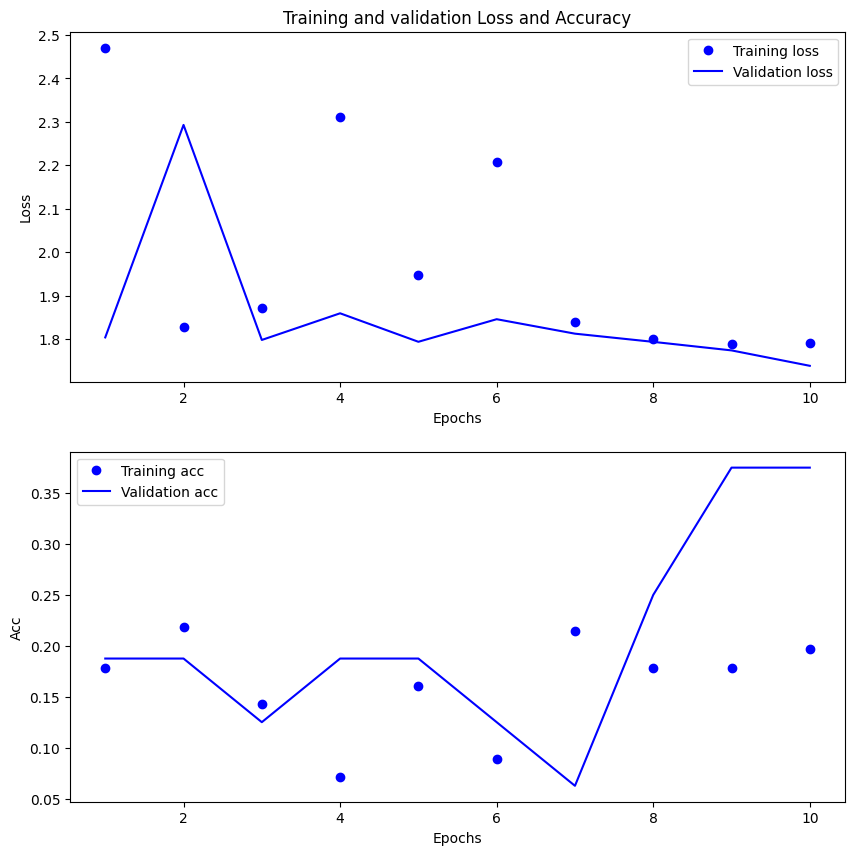

In [123]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()